In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import datetime
import os
import pickle
import scipy
import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import skies


In [3]:
run_name = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
base_runs_folder = "./runs/"
output_path = os.path.join(base_runs_folder, run_name)
mesh_parameters_file_name = "western_north_america_mesh_parameters.json"
skies.create_output_folder(base_runs_folder, output_path)
meshes = skies.read_meshes(mesh_parameters_file_name)
skies.print_magnitude_overview(meshes)


output_path='./runs/2022_11_01_17_10_50'
Read: western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

Read: cascadia.msh
Magnitude overview:
Maximum moment magnitude of entire mesh = 10.61
Maximum moment magnitude of single mesh element = 6.90
Minimum moment magnitude of single mesh element = 5.52


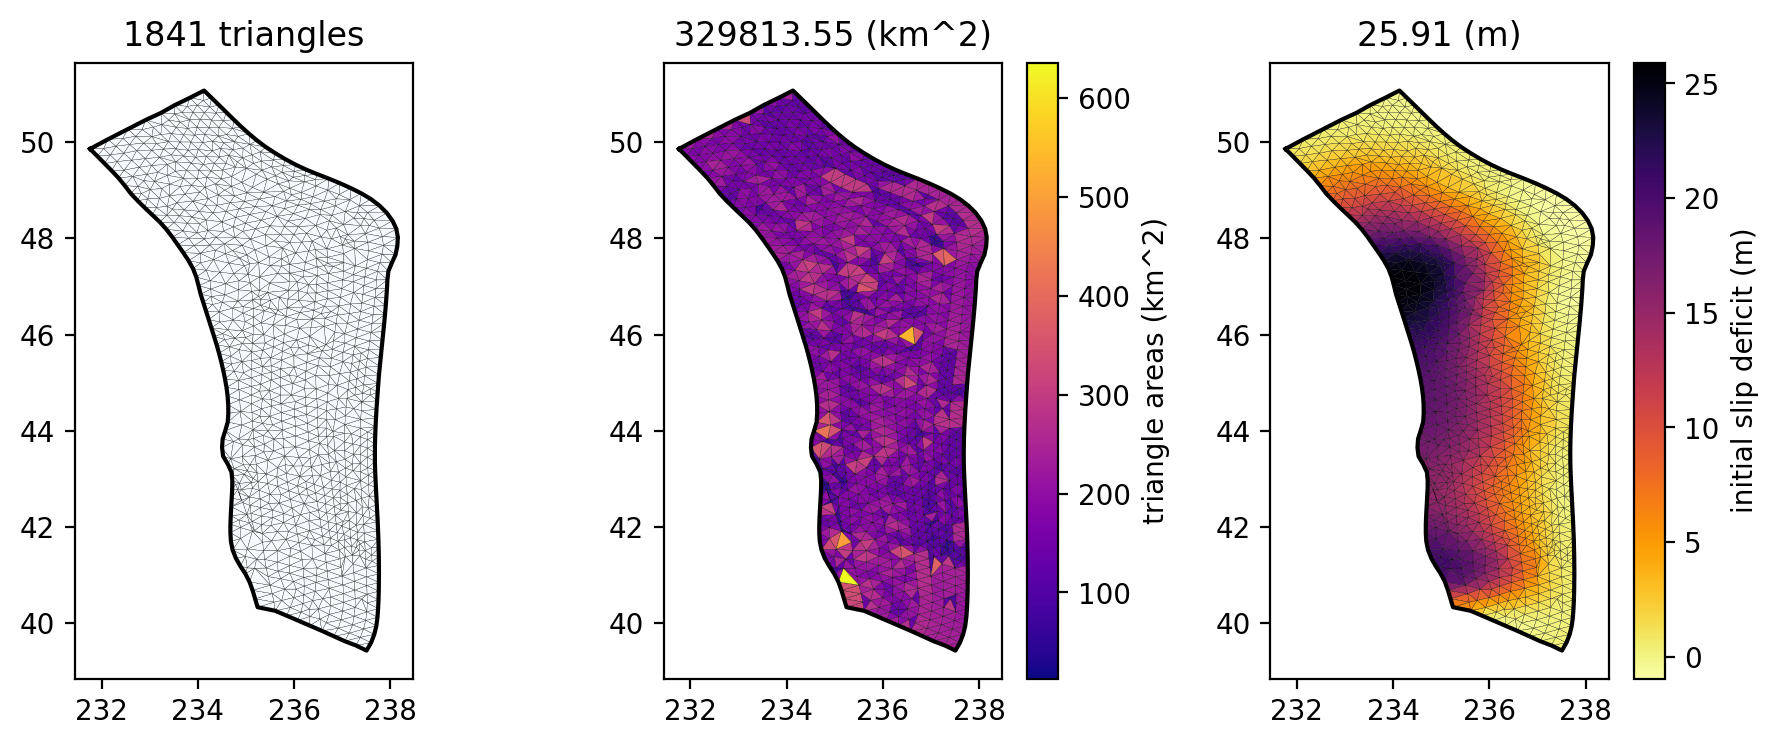

In [4]:
# Load initial slip defict and multiply by time cascadia_low_resolution_tde_dip_slip_rates.npy
initial_dip_slip_deficit = np.load("cascadia_low_resolution_tde_dip_slip_rates.npy")
total_coseismic_slip = np.zeros_like(initial_dip_slip_deficit)
skies.plot_initial_data(meshes, initial_dip_slip_deficit)


In [5]:
np.random.seed(1)


MM2M = 1e-3  # millimeters to meters
SECONDS_IN_A_YEAR = 60 * 60 * 24 * 365
DAYS_IN_A_YEAR = 365
n_years = 1000

time_vector = np.linspace(0, n_years, n_years * 1)
print(f"{time_vector.shape}")
minimum_probability = 1e-5
time_probability_weight = np.zeros_like(time_vector)
time_magnitude = np.zeros_like(time_vector)
time_probability = np.zeros_like(time_vector)
time_probability = minimum_probability * np.ones_like(time_vector)
new_time_probability = np.zeros_like(time_vector)
new_time_probability_asdf = np.zeros_like(time_vector)


# loading_rate = 30.0  # (mm/yr)
earthquake_index_list = []
earthquake_magnitude_list = []
earthquake_probability_list = []
event_trigger_list = []


# Intial geometric moment and storage
mesh_geometric_moment = 1e-7 * initial_dip_slip_deficit * meshes[0].areas
pre_event_mesh_geometric_moment = np.copy(mesh_geometric_moment)
post_event_mesh_geometric_moment = np.zeros_like(mesh_geometric_moment)
mesh_geometric_moment_scalar = np.zeros_like(time_vector)
mesh_geometric_moment_scalar_non_zero = np.zeros_like(time_vector)
mesh_geometric_moment_scalar[0] = np.sum(initial_dip_slip_deficit * meshes[0].areas)


interseismic_loading_rate = 5e1 * initial_dip_slip_deficit

# Parameters for model run
params = addict.Dict()
params.time_step = 5e-7
params.b_value = -1.0
params.shear_modulus = 3e10
params.n_samples = 1
params.minimum_event_moment_magnitude = 5.0
params.maximum_event_moment_magnitude = 9.0
params.time_probability_amplitude_scale_factor = 1.0
params.area_scaling = 1.25
params.time_probability_data_scale_factor = 1.0
params.location_probability_amplitude_scale_factor = 1.0
params.location_probability_data_scale_factor = 1e-5
params.omori_amplitude_scale_factor = 1e-21
params.omori_rate_perturbation_scale_factor = 1e-1

# Main time loop
for i in range(0, len(time_vector) - 1):
    # Determine whether there is an event at this time step
    time_probability_weight[i] = skies.get_tanh_probability(
        new_time_probability[i],
        params.time_probability_amplitude_scale_factor,
        params.time_probability_data_scale_factor,
    )
    event_trigger = np.random.choice(
        2, params.n_samples, p=[1 - time_probability_weight[i], time_probability_weight[i]]
    )
    event_trigger_list.append(event_trigger)

    if event_trigger == 1:
        event = addict.Dict()
        event.shear_modulus = np.array([params.shear_modulus])
        event.area_scaling = params.area_scaling
        event.moment_magnitude = skies.get_gutenberg_richter_magnitude(
            params.b_value,
            params.minimum_event_moment_magnitude,
            params.maximum_event_moment_magnitude,
        )
        event.moment = skies.moment_magnitude_to_moment(event.moment_magnitude)
        event.geometric_moment = event.moment / event.shear_modulus
        time_magnitude[i] = event.moment_magnitude[0]

        # Find event hypocentral triangle
        event.location_probability = skies.get_tanh_probability_vector(
            pre_event_mesh_geometric_moment,
            params.location_probability_amplitude_scale_factor,
            params.location_probability_data_scale_factor,
        )
        event.hypocenter_triangle_index = np.random.choice(
            meshes[0].n_tde, params.n_samples, p=event.location_probability
        )[0]

        # Generate coseismic slip area and slip distribution
        event = skies.get_event_area_slip_triangle_index(meshes[0], event)
        event.pre_event_mesh_geometric_moment = np.copy(pre_event_mesh_geometric_moment)
        event.post_event_mesh_geometric_moment = np.copy(
            pre_event_mesh_geometric_moment
            - (event.slip_all_elements * meshes[0].areas)
        )

        earthquake_magnitude_list.append(event.moment_magnitude)
        earthquake_index_list.append(i)

        # Generate Omori rate decay
        event.omori_amplitude = params.omori_amplitude_scale_factor * event.moment
        event.omori_decay_time = 20.0
        omori_rate_perturbation = skies.get_omori_decay_probability(
            time_vector,
            time_vector[i],
            event.omori_amplitude,
            decay_time=event.omori_decay_time,
        )

        # Coseismic offset to Omori rate effect
        omori_rate_perturbation[np.where(time_vector > time_vector[i])] -= (
            event.omori_amplitude * params.omori_rate_perturbation_scale_factor
        )

        # Store Omori rate decay
        earthquake_probability_list.append(omori_rate_perturbation)

        # Subtract event from the geometric moment mesh
        mesh_geometric_moment -= event.slip_all_elements * meshes[0].areas

        # Plot event
        # skies.plot_event(
        #     event,
        #     meshes,
        #     event.pre_event_mesh_geometric_moment,
        #     event.location_probability,
        #     event.post_event_mesh_geometric_moment,
        #     i,
        #     i,
        # )

        # Save event dictionary as pickle file
        event_pickle_file_name = f"{output_path}/event_{i:010.0f}.pickle"
        with open(event_pickle_file_name, "wb") as pickle_file:
            pickle.dump(event, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

    # Update mesh_geometric_moment
    mesh_geometric_moment += (
        params.time_step * interseismic_loading_rate * meshes[0].areas
    )
    mesh_geometric_moment_scalar[i + 1] = np.sum(mesh_geometric_moment)
    mesh_geometric_moment_scalar_non_zero[i + 1] = np.sum(
        mesh_geometric_moment[np.where(mesh_geometric_moment > 0.0)]
    )

    # Pre-event moment for next time step
    pre_event_mesh_geometric_moment = np.copy(mesh_geometric_moment)

    # Update probability
    new_time_probability[i + 1] = mesh_geometric_moment_scalar_non_zero[i + 1]
    new_time_probability_asdf[i + 1] = np.copy(new_time_probability[i + 1])

    # Sum contribution from all past earthquakes
    # TODO: The scaling factor here is magic
    for j in range(len(earthquake_index_list)):
        new_time_probability[i + 1] += 1e11 * earthquake_probability_list[j][i + 1]


(1000,)
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triangle area
Target area is less than hypocenter triang

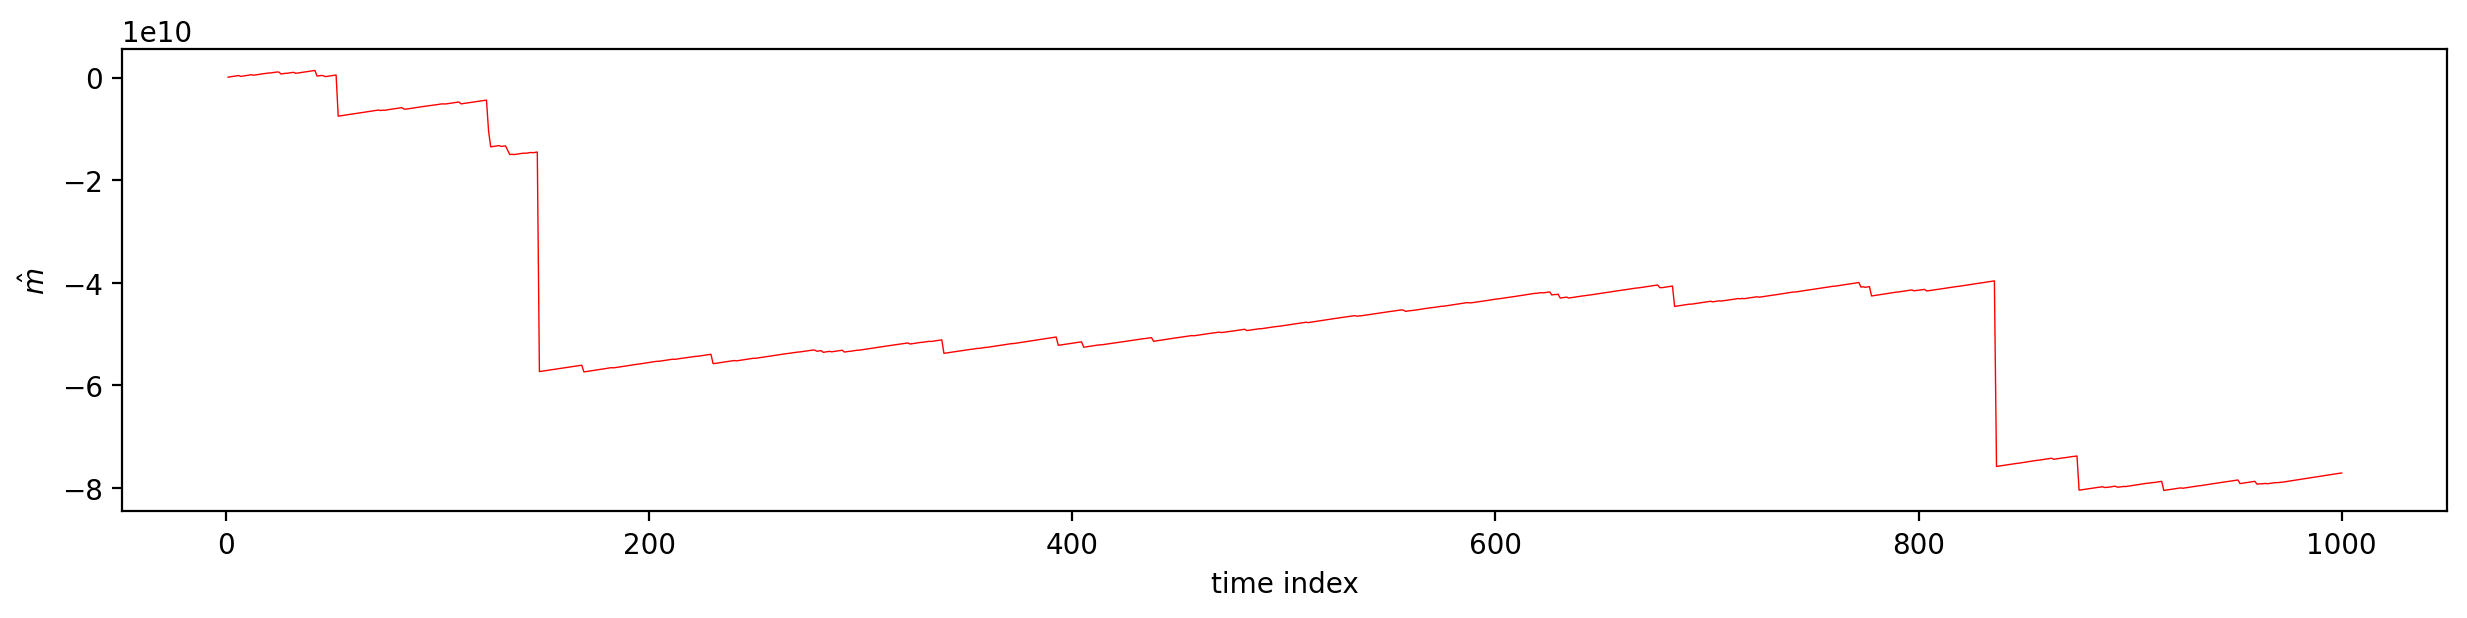

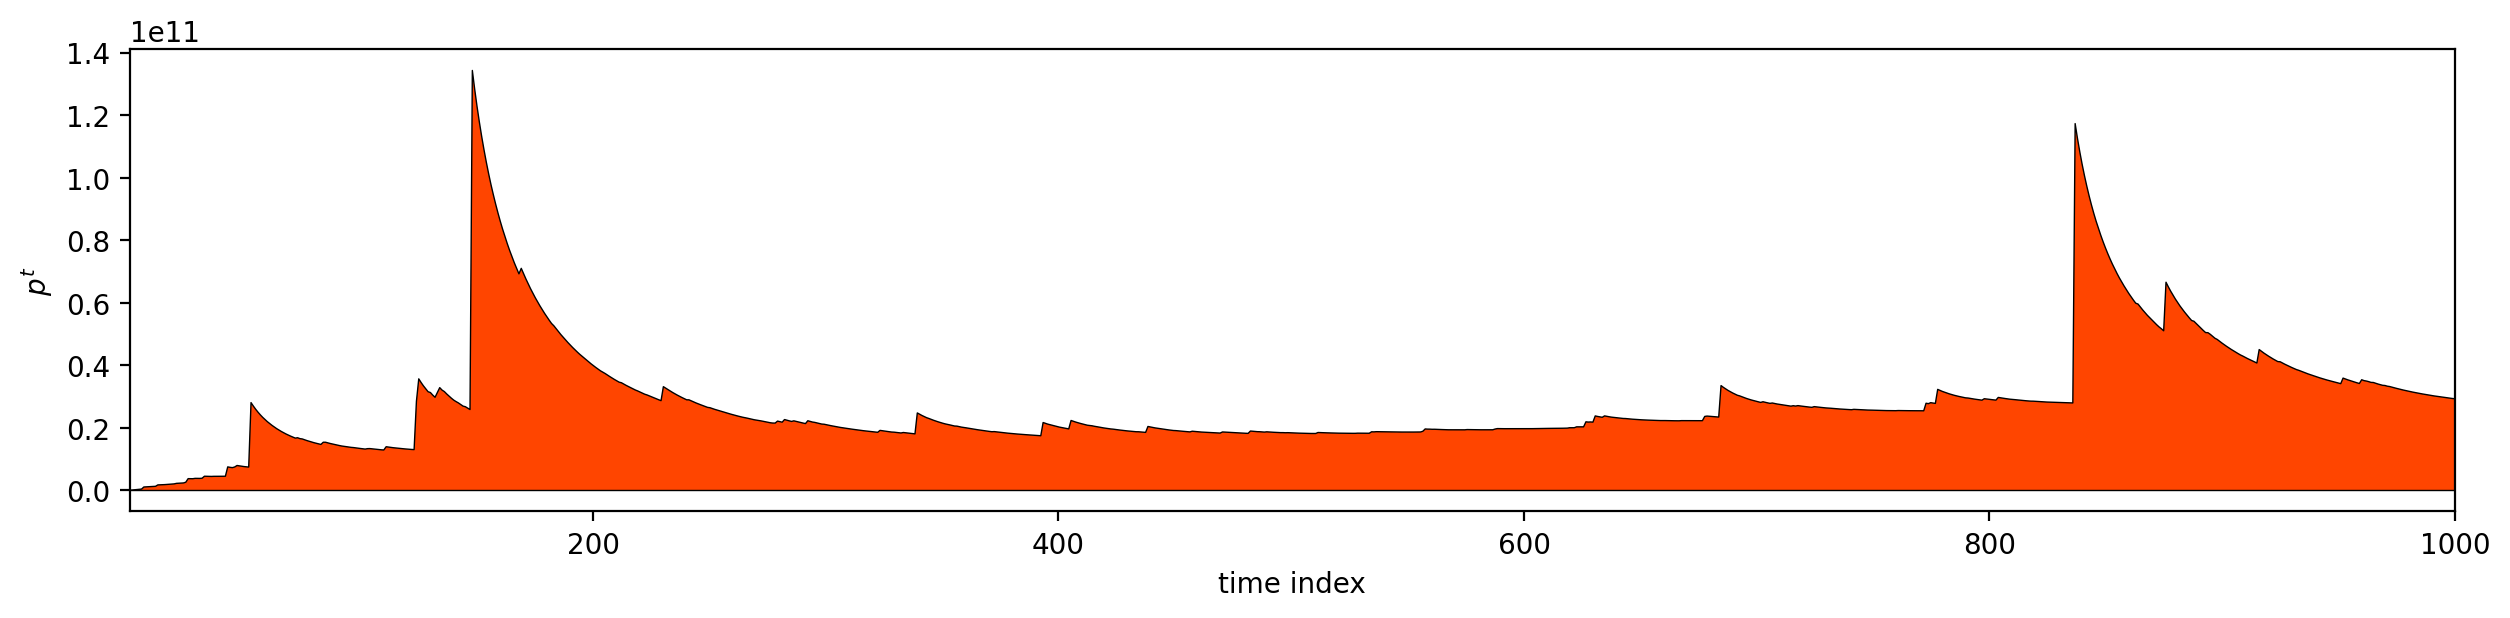

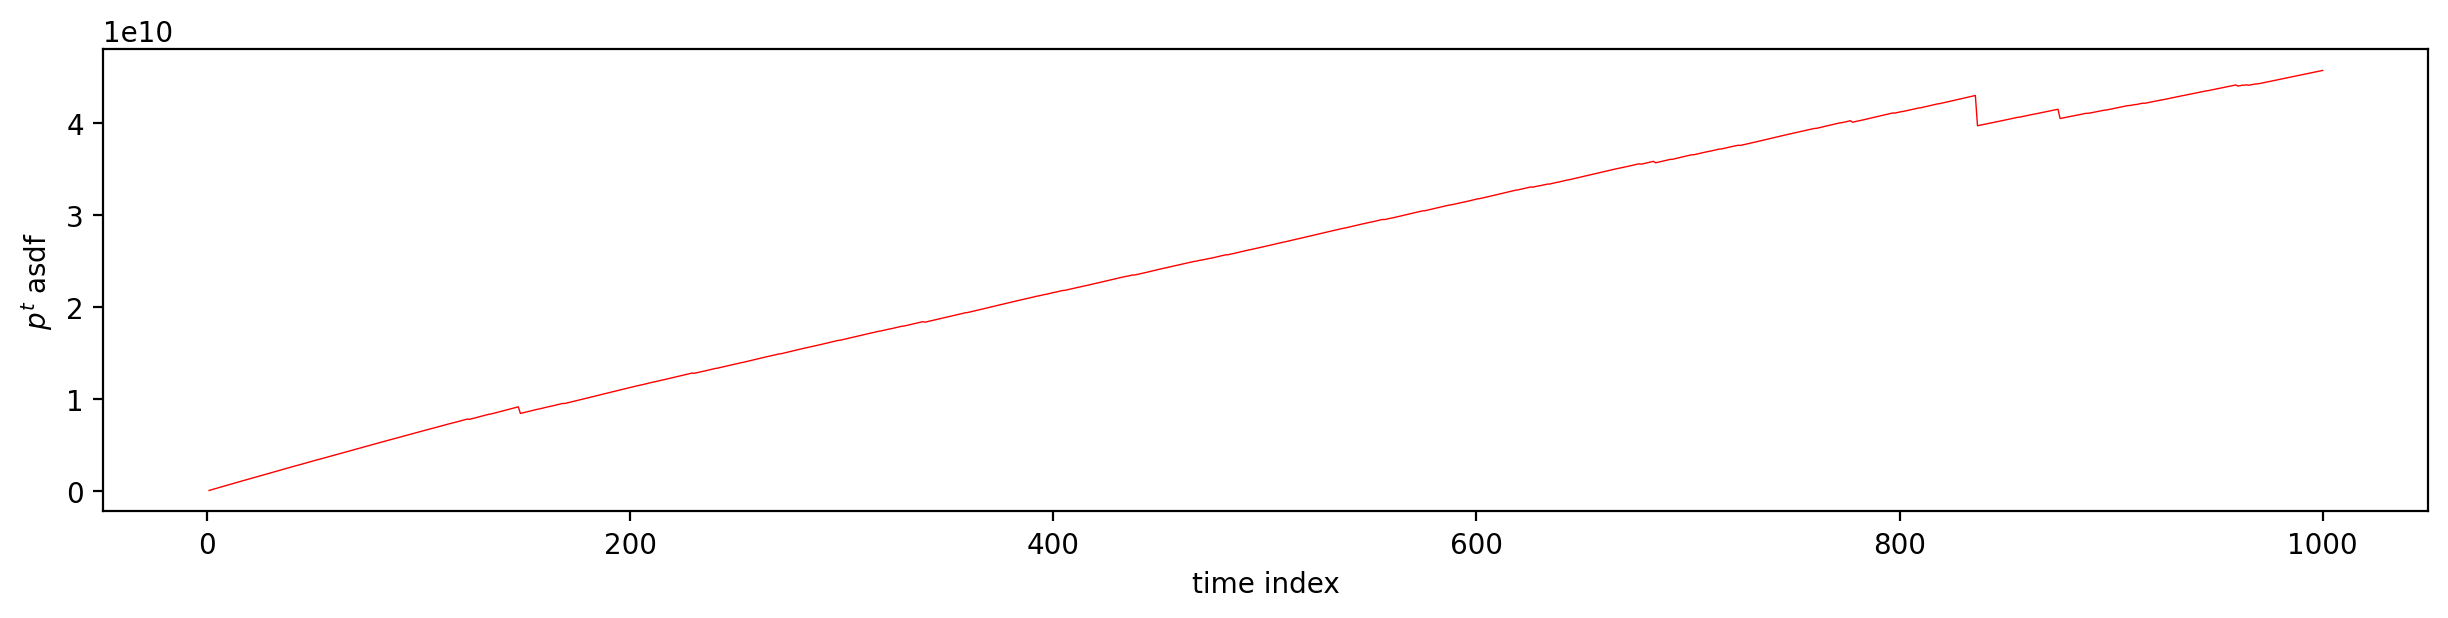

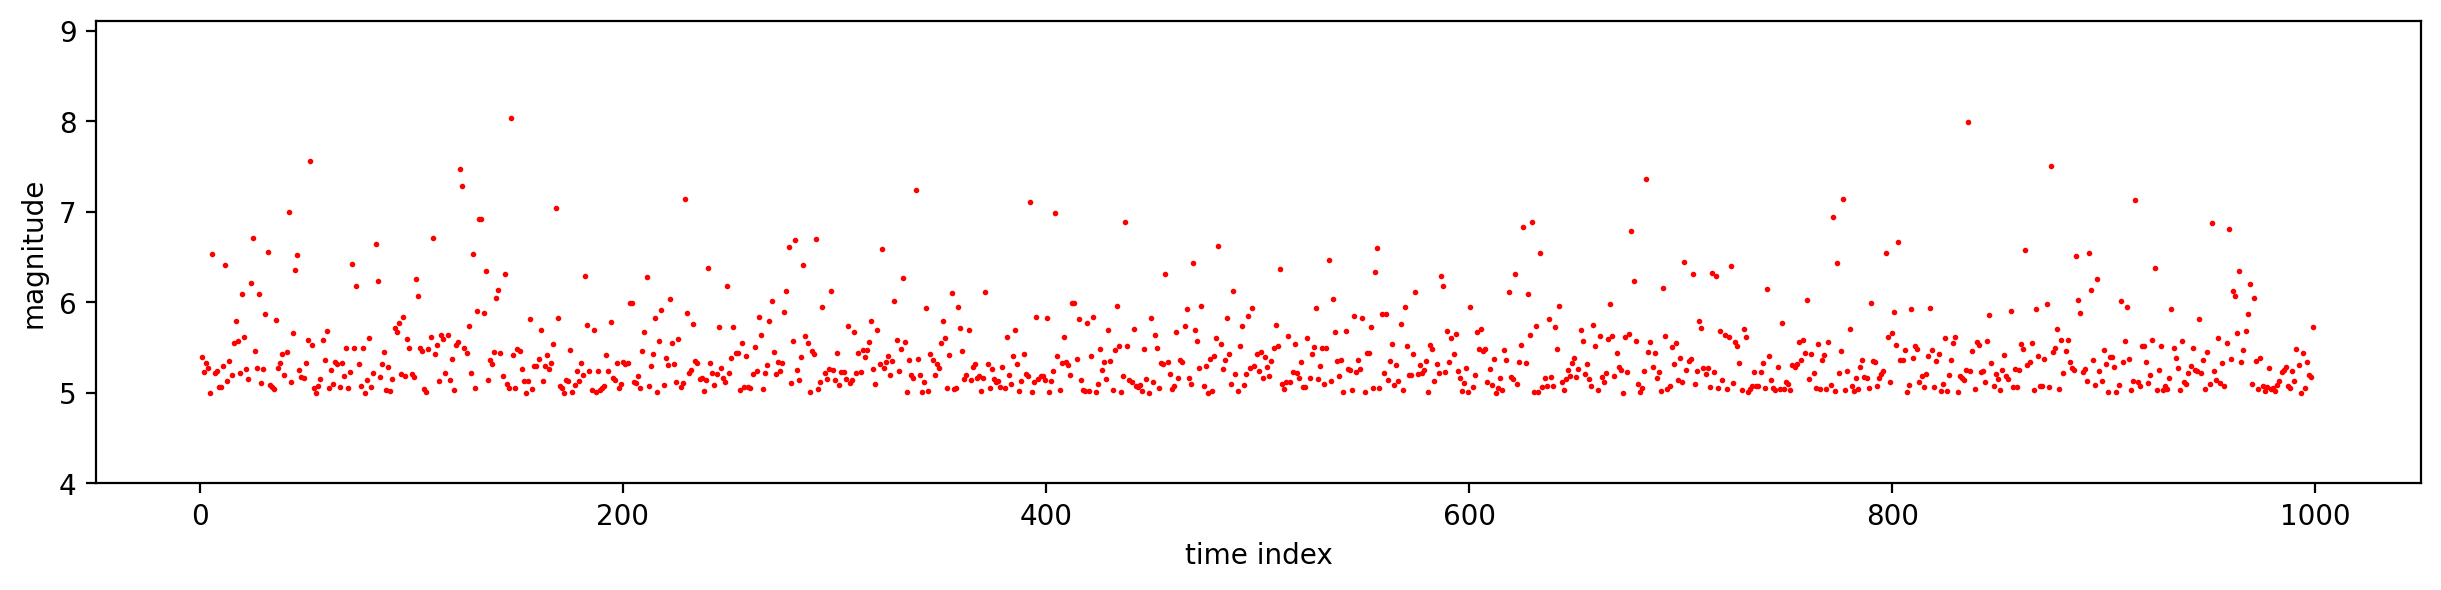

In [6]:
start_idx = 1
end_idx = 400000
end_idx = time_vector.size
figsize = (15, 3)

plt.figure(figsize=figsize)
plt.plot(
    time_vector[start_idx:end_idx],
    mesh_geometric_moment_scalar[start_idx:end_idx],
    "-r",
    linewidth=0.5,
)
plt.xlabel("time index")
plt.ylabel("$\hat{m}$")

# Probability evolution
plt.figure(figsize=figsize)
plt.plot(
    time_vector[start_idx:end_idx],
    new_time_probability[start_idx:end_idx],
    "-k",
    linewidth=0.5,
)
plt.plot([time_vector[start_idx], time_vector[end_idx-1]], [0, 0], "-k", linewidth=0.5)
plt.fill_between(
    time_vector[start_idx:end_idx],
    new_time_probability[start_idx:end_idx],
    np.zeros_like(time_vector[start_idx:end_idx]),
    new_time_probability[start_idx:end_idx] > 0,
    color="orangered",
    alpha=1.0,
    edgecolor=None,
)

plt.fill_between(
    time_vector[start_idx:end_idx],
    new_time_probability[start_idx:end_idx],
    np.zeros_like(time_vector[start_idx:end_idx]),
    new_time_probability[start_idx:end_idx] < 0,
    color="dodgerblue",
    alpha=1.0,
    edgecolor=None,
)
plt.xlim([start_idx, end_idx])
plt.xlabel("time index")
plt.ylabel("$p^t$")

plt.figure(figsize=figsize)
plt.plot(
    time_vector[start_idx:end_idx],
    new_time_probability_asdf[start_idx:end_idx],
    "-r",
    linewidth=0.5,
)
plt.xlabel("time index")
plt.ylabel("$p^t$ asdf")

plt.figure(figsize=figsize)
plt.plot(
    time_vector[start_idx:end_idx],
    time_magnitude[start_idx:end_idx],
    ".r",
    linewidth=0.5, markersize=2,
)
plt.ylim([4.0, 9.1])
plt.xlabel("time index")
plt.ylabel("magnitude")
plt.show()


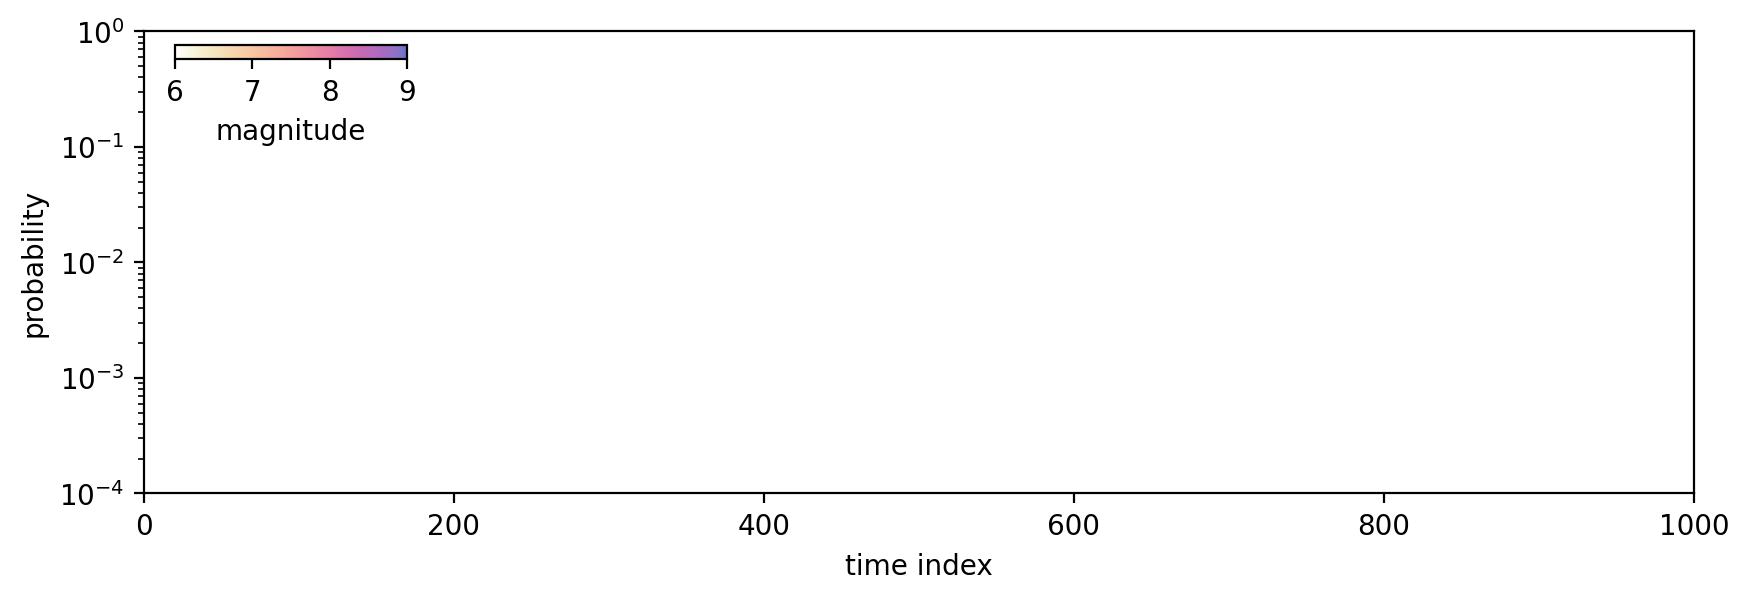

/Users/meade/mambaforge/envs/skies/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


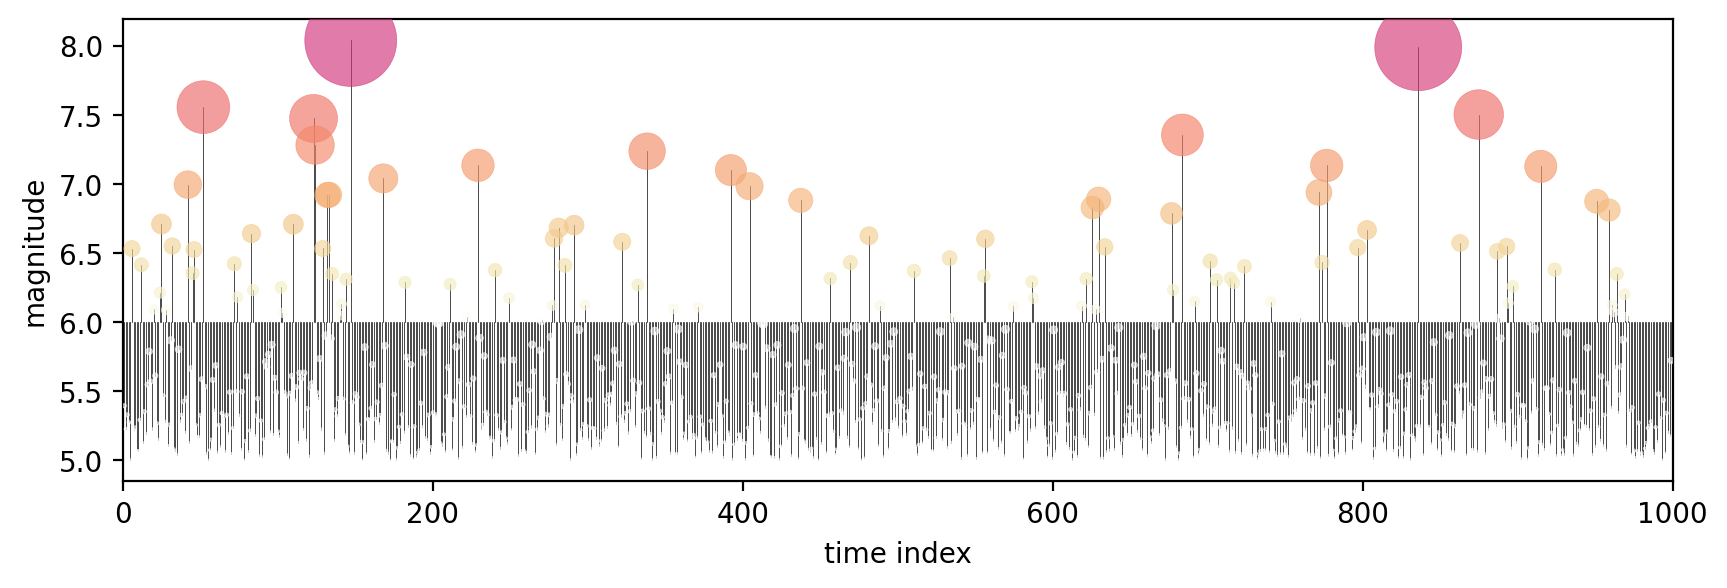

In [7]:
# Probability in time: Semilogy plot
plt.figure(figsize=(10, 3))
plt.semilogy(time_vector, time_probability, "-k", linewidth=0.5, zorder=35)
fill_x = np.append(time_vector, np.array([np.max(time_vector), 0]))
fill_y = np.append(
    time_probability, np.array([minimum_probability, minimum_probability])
)
plt.fill(
    fill_x,
    fill_y,
    color="lightsteelblue",
    alpha=1.0,
    edgecolor=None,
    zorder=10,
)

cmap = cc.cm.CET_L17
magnitude_plot_size = 1e-5 * 10 ** np.array(earthquake_magnitude_list)
plt.scatter(
    time_vector[earthquake_index_list],
    time_probability[earthquake_index_list],
    s=magnitude_plot_size,
    c=earthquake_magnitude_list,
    zorder=20,
    alpha=0.65,
    cmap=cmap,
    edgecolors=None,
    linewidths=0.25,
    vmin=6.0,
    vmax=9.0,
)
cb = plt.colorbar(
    cax=plt.gca().inset_axes((0.02, 0.94, 0.15, 0.03)),
    label="magnitude",
    orientation="horizontal",
    ticks=[6, 7, 8, 9],
)
cb.ax.tick_params(labelsize=10)

plt.plot(
    time_vector[earthquake_index_list],
    time_probability[earthquake_index_list],
    ".k",
    markersize=3,
    zorder=50,
)

plt.xlabel("time index")
plt.ylabel("probability")
plt.xlim([np.min(time_vector), np.max(time_vector)])
plt.ylim([1e-4, 1])
# plt.savefig("example_probability_time_series_semilogy.pdf")
# plt.savefig("example_probability_time_series_semilogy.png", dpi=500)
plt.show()

# Earthquake magnitude plot
plt.figure(figsize=(10, 3))
for i in range(len(earthquake_index_list)):
    plt.plot(
        [time_vector[earthquake_index_list[i]], time_vector[earthquake_index_list[i]]],
        [6.0, earthquake_magnitude_list[i]],
        "-",
        # markersize=10**(earthquake_magnitude_list[i] - 6),
        linewidth=0.25,
        zorder=10,
        color="k",
    )


cmap = cc.cm.CET_L17
magnitude_plot_size = 1e-5 * 10 ** np.array(earthquake_magnitude_list)
plt.scatter(
    time_vector[earthquake_index_list],
    earthquake_magnitude_list,
    s=magnitude_plot_size,
    c=earthquake_magnitude_list,
    zorder=20,
    alpha=0.65,
    cmap=cmap,
    edgecolors=None,
    linewidths=0.25,
    vmin=6.0,
    vmax=9.0,
)

# for i in range(len(earthquake_index_list)):
#     plt.plot(
#         time_vector[earthquake_index_list[i]],
#         earthquake_magnitude_list[i],
#         ".",
#         markersize=10 ** (earthquake_magnitude_list[i] - 6),
#         # markersize=10,
#         alpha=1.0,
#         linewidth=0.0,
#         zorder=20,
#         color="orange",
#         markeredgecolor="k",
#         markeredgewidth=0.25,
#     )
plt.xlabel("time index")
plt.ylabel("magnitude")
plt.xlim([np.min(time_vector), np.max(time_vector)])
# plt.ylim([6, 10])
# plt.grid(True, linewidth=0.5, linestyle="--")

# plt.savefig("example_magnitude_time_series_semilogy.pdf")
# plt.savefig("example_magnitude_time_series_semilogy.png", dpi=500)
plt.show()
